In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import GlobalAveragePooling2D


In [2]:
train=True
num_classes = 41
weight_decay = 0.0005
x_shape = [224,224,3]

In [3]:
def normalize(X_train,X_test):
    #this function normalize inputs for zero mean and unit variance
    # it is used when training a model.
    # Input: training set and test set
    # Output: normalized training set and test set according to the trianing set statistics.
    mean = np.mean(X_train,axis=(0,1,2,3))
    std = np.std(X_train, axis=(0, 1, 2, 3))
    print(mean)
    print(std)
    X_train = (X_train-mean)/(std+1e-7)
    X_test = (X_test-mean)/(std+1e-7)
    return X_train, X_test

def normalize_production(x):
    #this function is used to normalize instances in production according to saved training set statistics
    # Input: X - a training set
    # Output X - a normalized training set according to normalization constants.

    #these values produced during first training and are general for the standard cifar10 training set normalization
    mean = 121.936
    std = 68.389
    return (x-mean)/(std+1e-7)

In [4]:
def predict(x,normalize=True,batch_size=32):
    if normalize:
        x = normalize_production(x)
    return model.predict(x,batch_size)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
def load_and_split_data(data_dir, target_size=(64,64), test_split=0.2, batch_size=32):
    """
    Load and split image dataset from Kaggle into x_train, x_test, y_train, y_test.

    Parameters:
    - data_dir: Path to the dataset directory with subfolders for each breed.
    - target_size: Tuple for image resizing (height, width).
    - test_split: Fraction of data for testing (default: 0.2).
    - batch_size: Batch size for data loading (default: 32).

    Returns:
    - x_train, x_test: NumPy arrays of training and testing images.
    - y_train, y_test: NumPy arrays of training and testing labels (one-hot encoded).
    """
    # Initialize ImageDataGenerator for preprocessing
    datagen = ImageDataGenerator(
        rescale=1./255,  # Normalize pixel values to [0,1]
        validation_split=test_split  # Split for testing
    )

    # Load training data
    train_generator = datagen.flow_from_directory(
        data_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',  # One-hot encoded labels for multi-class
        subset='training',
        shuffle=True,
        seed=42
    )




    # Initialize lists to store images and labels
    x_train, y_train = [], []
    x_test, y_test = [], []

    # Collect training data
    for i in range(len(train_generator)):
        images, labels = train_generator[i]
        x_train.append(images)
        y_train.append(labels)

    # Collect test

    # Concatenate batches into NumPy arrays
    x_train = np.concatenate(x_train, axis=0)
    y_train = np.concatenate(y_train, axis=0)
    x_test = np.concatenate(x_test, axis=0)
    y_test = np.concatenate(y_test, axis=0)

    return x_train, x_test, y_train, y_test

In [7]:
x_train, x_test, y_train, y_test = load_and_split_data(data_dir='/content/drive/MyDrive/Indian_bovine_breeds')

Found 4786 images belonging to 41 classes.
Found 1171 images belonging to 41 classes.


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [14]:
for i in range 41:
print(labels[i])

SyntaxError: invalid syntax (ipython-input-2523134467.py, line 1)

In [8]:


def identity_block(input_tensor, filters, kernel_size=3):
    filters1, filters2, filters3 = filters

    x = layers.Conv2D(filters1, 1, padding='valid')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, 1, padding='valid')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Add()([x, input_tensor])
    x = layers.Activation('relu')(x)
    return x

def conv_block(input_tensor, filters, kernel_size=3, strides=2):
    filters1, filters2, filters3 = filters

    x = layers.Conv2D(filters1, 1, strides=strides, padding='valid')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, 1, padding='valid')(x)
    x = layers.BatchNormalization()(x)

    shortcut = layers.Conv2D(filters3, 1, strides=strides, padding='valid')(input_tensor)
    shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

def ResNet50(input_shape=(64, 64, 3), classes=41):
    img_input = layers.Input(shape=input_shape)

    x = layers.Conv2D(64, 7, strides=2, padding='same')(img_input)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    # Stage 1
    x = conv_block(x, [64, 64, 256], strides=1)
    x = identity_block(x, [64, 64, 256])
    x = identity_block(x, [64, 64, 256])

    # Stage 2
    x = conv_block(x, [128, 128, 512])
    x = identity_block(x, [128, 128, 512])
    x = identity_block(x, [128, 128, 512])
    x = identity_block(x, [128, 128, 512])

    # Stage 3
    x = conv_block(x, [256, 256, 1024])
    x = identity_block(x, [256, 256, 1024])
    x = identity_block(x, [256, 256, 1024])
    x = identity_block(x, [256, 256, 1024])
    x = identity_block(x, [256, 256, 1024])
    x = identity_block(x, [256, 256, 1024])

    # Stage 4
    x = conv_block(x, [512, 512, 2048])
    x = identity_block(x, [512, 512, 2048])
    x = identity_block(x, [512, 512, 2048])

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(classes, activation='softmax')(x)

    model = Model(img_input, x, name='resnet50')



    return model



In [9]:
model=ResNet50()

from google.colab import drive
drive.mount('/content/drive')

In [10]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)
from tensorflow.keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=1)

In [11]:
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.15, patience=3, min_lr=1e-6),
    TensorBoard(log_dir='./logs')
]

In [12]:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images

# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

#optimization details
adam = keras.optimizers.SGD(learning_rate=0.01,momentum=0.8)

# Compile for a single-output model
model.compile(loss='categorical_crossentropy', optimizer=adam,metrics=['accuracy'])

batch_size = 32
epochs = 200

# Fit the model using ImageDataGenerator and validation data
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=x_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test), # x_test and y_test have the correct shapes now
    verbose=2,
    callbacks=callbacks
)

model.save('resnet.h5')


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/200


149/149 - 65s - 439ms/step - accuracy: 0.0700 - loss: 4.8372 - val_accuracy: 0.0307 - val_loss: 23.2919 - learning_rate: 0.0100
Epoch 2/200


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


149/149 - 2s - 13ms/step - accuracy: 0.1250 - loss: 3.8323 - val_accuracy: 0.0504 - val_loss: 18.2086 - learning_rate: 0.0100
Epoch 3/200


149/149 - 42s - 279ms/step - accuracy: 0.1237 - loss: 3.6067 - val_accuracy: 0.1221 - val_loss: 8.6819 - learning_rate: 0.0100
Epoch 4/200
149/149 - 1s - 3ms/step - accuracy: 0.0625 - loss: 3.5495 - val_accuracy: 0.1178 - val_loss: 9.0839 - learning_rate: 0.0100
Epoch 5/200


149/149 - 10s - 68ms/step - accuracy: 0.1430 - loss: 3.3396 - val_accuracy: 0.1554 - val_loss: 8.6374 - learning_rate: 0.0100
Epoch 6/200
149/149 - 1s - 4ms/step - accuracy: 0.2500 - loss: 3.0517 - val_accuracy: 0.1469 - val_loss: 9.7770 - learning_rate: 0.0100
Epoch 7/200
149/149 - 8s - 56ms/step - accuracy: 0.1744 - loss: 3.1980 - val_accuracy: 0.1537 - val_loss: 3.2421 - learning_rate: 0.0100
Epoch 8/200


149/149 - 2s - 13ms/step - accuracy: 0.0625 - loss: 3.3276 - val_accuracy: 0.1648 - val_loss: 3.2760 - learning_rate: 0.0100
Epoch 9/200


149/149 - 10s - 64ms/step - accuracy: 0.1767 - loss: 3.1163 - val_accuracy: 0.1845 - val_loss: 3.0083 - learning_rate: 0.0100
Epoch 10/200


149/149 - 2s - 11ms/step - accuracy: 0.1875 - loss: 2.8362 - val_accuracy: 0.1956 - val_loss: 2.9976 - learning_rate: 0.0100
Epoch 11/200
149/149 - 9s - 60ms/step - accuracy: 0.1866 - loss: 3.0511 - val_accuracy: 0.1742 - val_loss: 3.3709 - learning_rate: 0.0100
Epoch 12/200
149/149 - 1s - 5ms/step - accuracy: 0.2188 - loss: 2.7739 - val_accuracy: 0.1674 - val_loss: 3.3424 - learning_rate: 0.0100
Epoch 13/200
149/149 - 9s - 61ms/step - accuracy: 0.1975 - loss: 2.9766 - val_accuracy: 0.1716 - val_loss: 3.0582 - learning_rate: 0.0100
Epoch 14/200
149/149 - 1s - 5ms/step - accuracy: 0.1562 - loss: 2.9817 - val_accuracy: 0.1571 - val_loss: 3.0794 - learning_rate: 0.0015
Epoch 15/200


149/149 - 10s - 67ms/step - accuracy: 0.2383 - loss: 2.7611 - val_accuracy: 0.2272 - val_loss: 2.8146 - learning_rate: 0.0015
Epoch 16/200
149/149 - 1s - 4ms/step - accuracy: 0.3125 - loss: 2.7805 - val_accuracy: 0.2272 - val_loss: 2.8157 - learning_rate: 0.0015
Epoch 17/200


149/149 - 10s - 64ms/step - accuracy: 0.2583 - loss: 2.6454 - val_accuracy: 0.2289 - val_loss: 2.8199 - learning_rate: 0.0015
Epoch 18/200
149/149 - 1s - 5ms/step - accuracy: 0.2188 - loss: 2.4834 - val_accuracy: 0.2263 - val_loss: 2.8221 - learning_rate: 0.0015
Epoch 19/200


149/149 - 20s - 137ms/step - accuracy: 0.2690 - loss: 2.5822 - val_accuracy: 0.2374 - val_loss: 2.8629 - learning_rate: 0.0015
Epoch 20/200
149/149 - 1s - 5ms/step - accuracy: 0.3125 - loss: 2.7317 - val_accuracy: 0.2289 - val_loss: 2.8725 - learning_rate: 0.0015
Epoch 21/200
149/149 - 9s - 62ms/step - accuracy: 0.2867 - loss: 2.5375 - val_accuracy: 0.2314 - val_loss: 2.9107 - learning_rate: 0.0015
Epoch 22/200
149/149 - 1s - 5ms/step - accuracy: 0.1562 - loss: 2.9582 - val_accuracy: 0.2323 - val_loss: 2.9145 - learning_rate: 0.0015
Epoch 23/200


149/149 - 10s - 67ms/step - accuracy: 0.2974 - loss: 2.4701 - val_accuracy: 0.2417 - val_loss: 2.8752 - learning_rate: 2.2500e-04
Epoch 24/200
149/149 - 1s - 5ms/step - accuracy: 0.2500 - loss: 2.3236 - val_accuracy: 0.2417 - val_loss: 2.8756 - learning_rate: 2.2500e-04
Epoch 25/200
149/149 - 18s - 123ms/step - accuracy: 0.3023 - loss: 2.4565 - val_accuracy: 0.2417 - val_loss: 2.8661 - learning_rate: 2.2500e-04
Epoch 26/200


149/149 - 2s - 10ms/step - accuracy: 0.2500 - loss: 2.7431 - val_accuracy: 0.2434 - val_loss: 2.8633 - learning_rate: 2.2500e-04
Epoch 27/200


149/149 - 10s - 68ms/step - accuracy: 0.3080 - loss: 2.4482 - val_accuracy: 0.2459 - val_loss: 2.8306 - learning_rate: 2.2500e-04
Epoch 28/200
149/149 - 1s - 5ms/step - accuracy: 0.2500 - loss: 2.2366 - val_accuracy: 0.2417 - val_loss: 2.8347 - learning_rate: 2.2500e-04
Epoch 29/200


149/149 - 20s - 135ms/step - accuracy: 0.3058 - loss: 2.4191 - val_accuracy: 0.2502 - val_loss: 2.8460 - learning_rate: 2.2500e-04
Epoch 30/200
149/149 - 1s - 4ms/step - accuracy: 0.2188 - loss: 2.3335 - val_accuracy: 0.2494 - val_loss: 2.8450 - learning_rate: 2.2500e-04
Epoch 31/200
149/149 - 9s - 62ms/step - accuracy: 0.3042 - loss: 2.4177 - val_accuracy: 0.2442 - val_loss: 2.8138 - learning_rate: 2.2500e-04
Epoch 32/200
149/149 - 1s - 4ms/step - accuracy: 0.2500 - loss: 2.2689 - val_accuracy: 0.2425 - val_loss: 2.8116 - learning_rate: 2.2500e-04
Epoch 33/200
149/149 - 9s - 57ms/step - accuracy: 0.3109 - loss: 2.3922 - val_accuracy: 0.2494 - val_loss: 2.8550 - learning_rate: 3.3750e-05
Epoch 34/200
149/149 - 1s - 4ms/step - accuracy: 0.4375 - loss: 2.2161 - val_accuracy: 0.2494 - val_loss: 2.8589 - learning_rate: 3.3750e-05


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Initialize lists to store results
results = []

# Load the best model (assuming it's saved with all layers, including custom objects if any)
#model = tf.keras.models.load_model('/content/googlenet.h5')


for i in range(100):
    # Get the test image and its true label
    image = x_test[i * 100]  # Shape: (224, 224, 3) after resizing
    true_class_one_hot = y_test[i * 100]  # Shape: (100,) - one-hot encoded vector
    true_class = np.argmax(true_class_one_hot)  # Get the index of the true class

    # Add batch dimension to the image
    image = np.expand_dims(image, axis=0)  # Shape: (1, 224, 224, 3)

    # Make prediction (model returns three outputs)
    predictions = model.predict(image)  # Returns a list: [main_output, aux_output_1, aux_output_2]
    predicted_class = np.argmax(predictions, axis=1)[0]  # Use main_output for final prediction
    confidence = np.max(predictions)  # Confidence from main_output

    # Store results in dictionary
    results.append({
        'Image_Index': i * 100,
        'Predicted_Class': cifar100_labels[predicted_class],
        'True_Class': cifar100_labels[true_class],
        'Confidence': f"{confidence:.4f}",
        'Correct': predicted_class == true_class
    })

    # Visualize the image
    plt.imshow(x_test[i * 100])  # Show original 32x32 image for visualization
    plt.title(f"Predicted: {cifar100_labels[predicted_class]}, True: {cifar100_labels[true_class]}")
    plt.show()

    # Print results
    print(f"Image {i * 100}:")
    print(f"Predicted Class: {predicted_class} ({cifar100_labels[predicted_class]})")
    print(f"True Class: {true_class} ({cifar100_labels[true_class]})")
    print(f"Confidence: {confidence:.4f}")
    print("Prediction is 1!" if predicted_class == true_class else "Prediction is 0.")
    print()

# Create and display DataFrame
results_df = pd.DataFrame(results)
print("\nPrediction Results Table:")
print(results_df)

# Optionally save to CSV
results_df.to_csv('/content/prediction_results.csv', index=False)  # Save to Google Drive

KeyboardInterrupt: 

In [ ]:
import pandas as pd

# Read the CSV file (replace 'data.csv' with your file name)
df = pd.read_csv('prediction_results.csv')

# Assume the boolean column is named 'value' (replace with your column name)
column_name = 'Correct'

# Calculate the percentage of True values
true_count = df[column_name].sum()  # True is treated as 1, False as 0
total_count = len(df)
true_percentage = (true_count / total_count) * 100

# Print the result
print(f"Percentage of True values: {true_percentage:.2f}%")

Percentage of True values: 46.00%


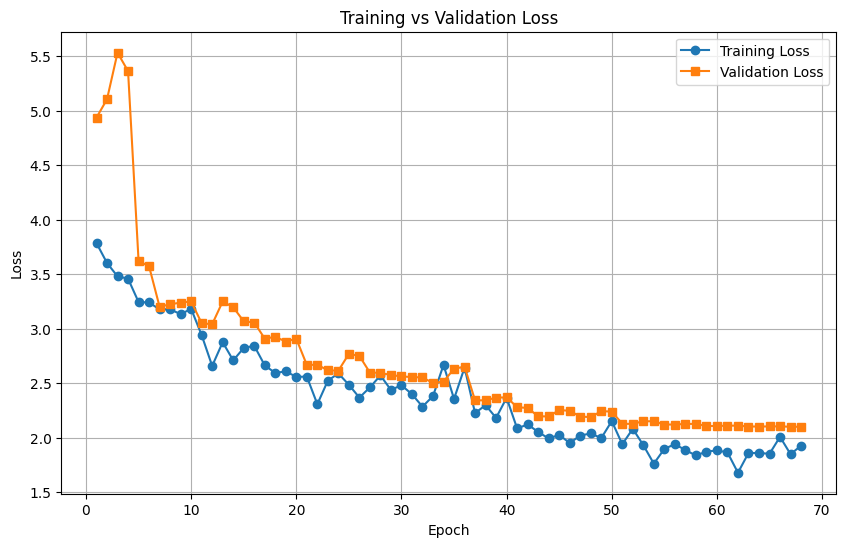

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_train_val_loss(train_loss, val_loss, epochs=None):
    if epochs is None:
        epochs = range(1, len(train_loss) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_loss, label='Training Loss', marker='o')
    plt.plot(epochs, val_loss, label='Validation Loss', marker='s')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_train_val_loss(history.history['loss'], history.history['val_loss'])

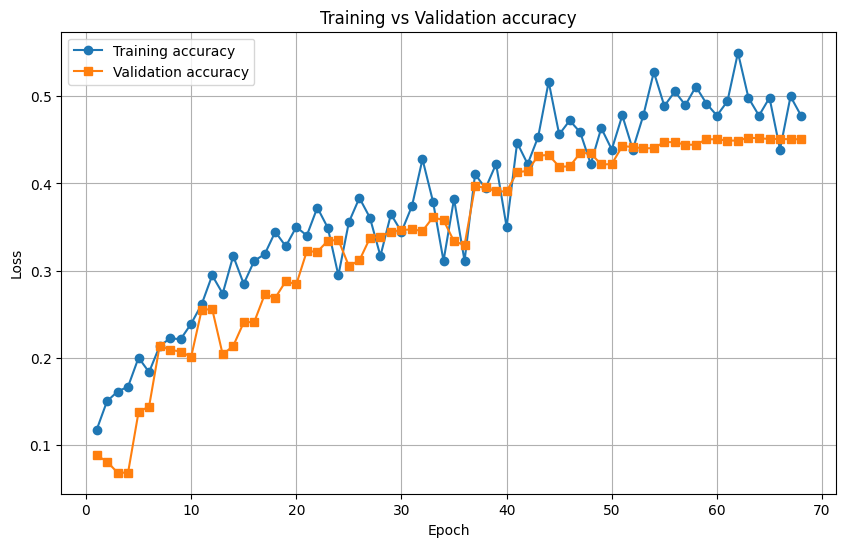

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_train_val_loss(train_loss, val_loss, epochs=None):
    if epochs is None:
        epochs = range(1, len(train_loss) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_loss, label='Training accuracy', marker='o')
    plt.plot(epochs, val_loss, label='Validation accuracy', marker='s')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_train_val_loss(history.history['accuracy'], history.history['val_accuracy'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


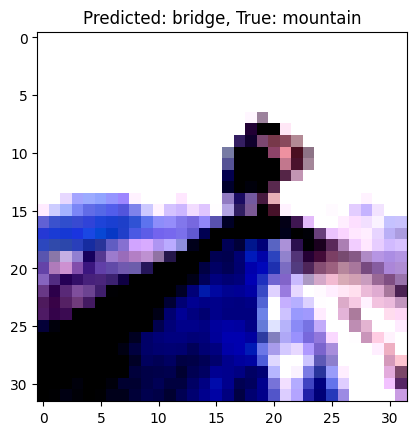

Image 0:
Predicted Class: 12 (bridge)
True Class: 49 (mountain)
Confidence: 0.4573
Prediction is 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


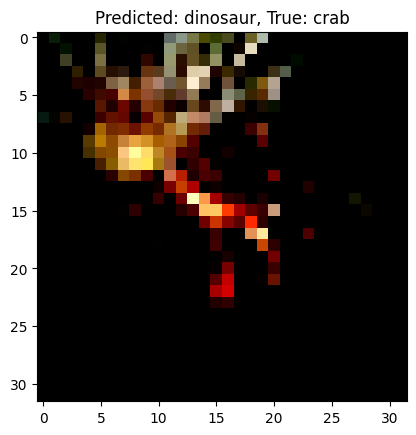

Image 100:
Predicted Class: 29 (dinosaur)
True Class: 26 (crab)
Confidence: 0.1000
Prediction is 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


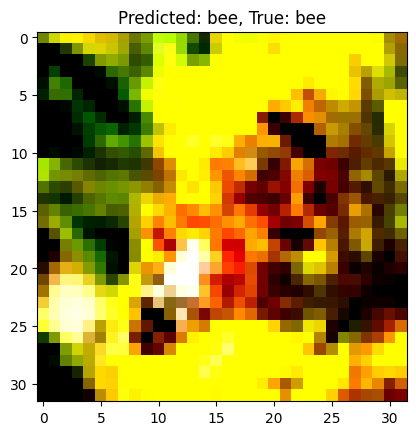

Image 200:
Predicted Class: 6 (bee)
True Class: 6 (bee)
Confidence: 0.3562
Prediction is 1!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


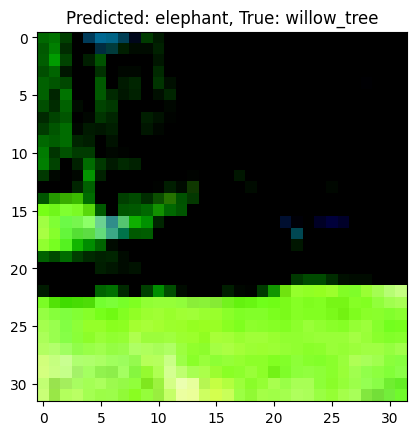

Image 300:
Predicted Class: 31 (elephant)
True Class: 96 (willow_tree)
Confidence: 0.1661
Prediction is 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


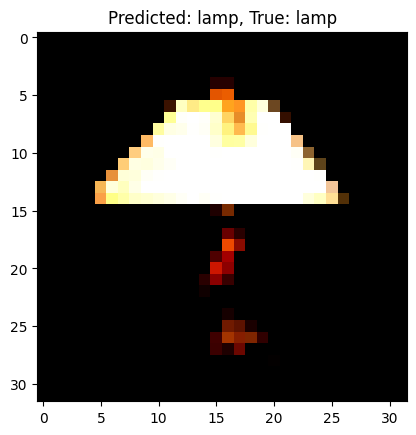

Image 400:
Predicted Class: 40 (lamp)
True Class: 40 (lamp)
Confidence: 0.8123
Prediction is 1!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


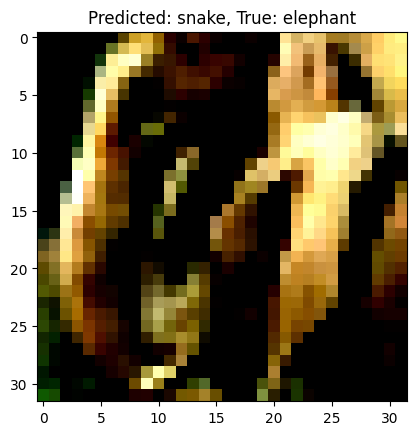

Image 500:
Predicted Class: 78 (snake)
True Class: 31 (elephant)
Confidence: 0.4729
Prediction is 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


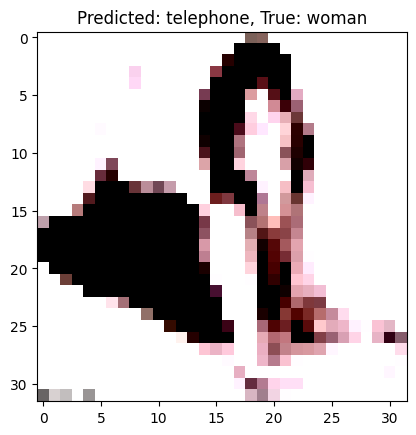

Image 600:
Predicted Class: 86 (telephone)
True Class: 98 (woman)
Confidence: 0.1272
Prediction is 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


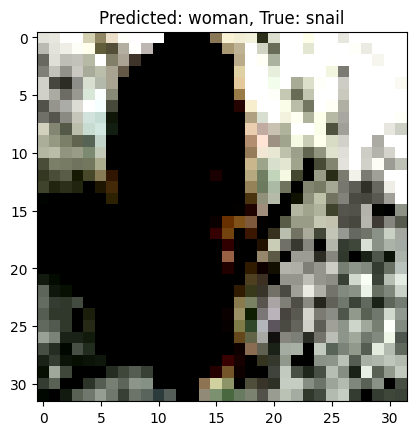

Image 700:
Predicted Class: 98 (woman)
True Class: 77 (snail)
Confidence: 0.1661
Prediction is 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


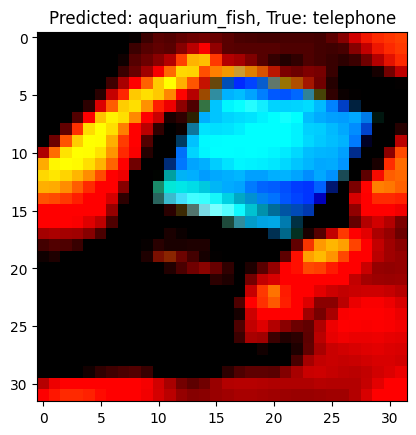

Image 800:
Predicted Class: 1 (aquarium_fish)
True Class: 86 (telephone)
Confidence: 0.2665
Prediction is 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


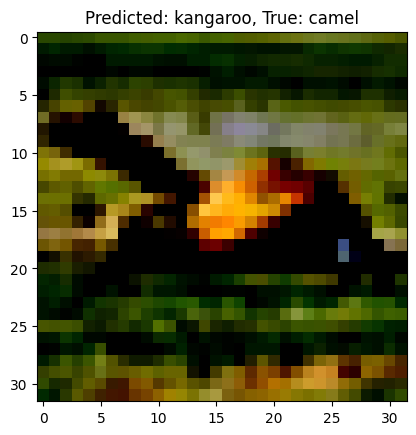

Image 900:
Predicted Class: 38 (kangaroo)
True Class: 15 (camel)
Confidence: 0.1676
Prediction is 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


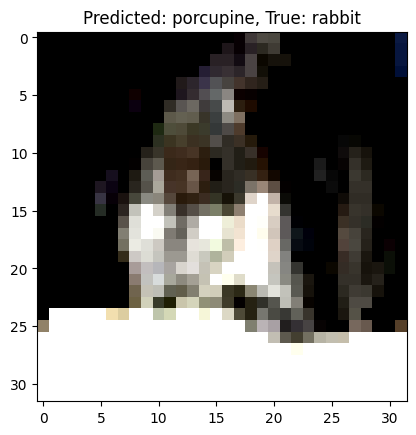

Image 1000:
Predicted Class: 63 (porcupine)
True Class: 65 (rabbit)
Confidence: 0.3732
Prediction is 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


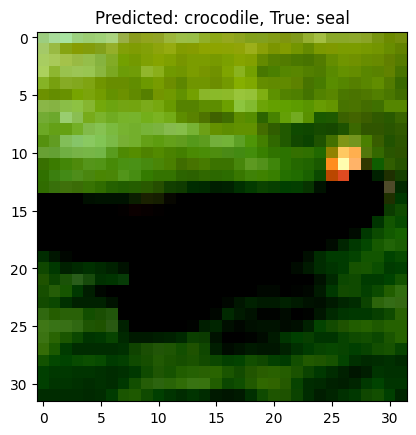

Image 1100:
Predicted Class: 27 (crocodile)
True Class: 72 (seal)
Confidence: 0.5011
Prediction is 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


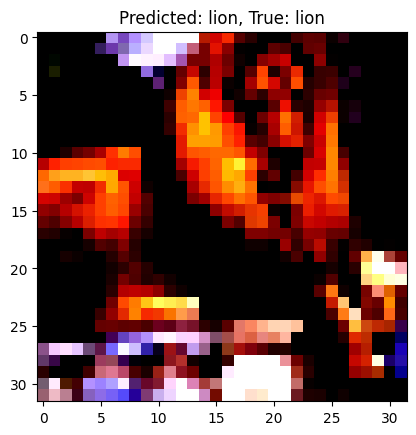

Image 1200:
Predicted Class: 43 (lion)
True Class: 43 (lion)
Confidence: 0.1527
Prediction is 1!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


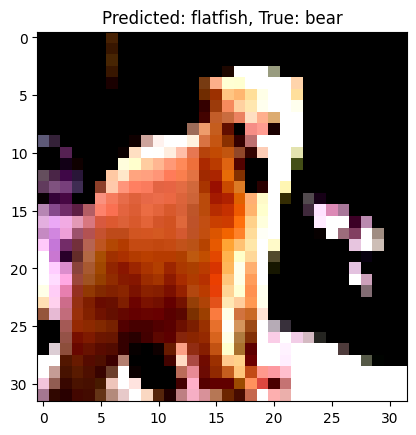

Image 1300:
Predicted Class: 32 (flatfish)
True Class: 3 (bear)
Confidence: 0.1025
Prediction is 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


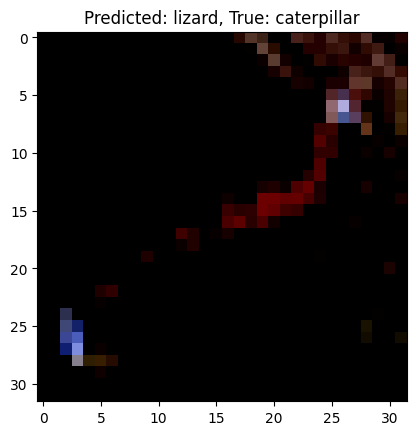

Image 1400:
Predicted Class: 44 (lizard)
True Class: 18 (caterpillar)
Confidence: 0.1292
Prediction is 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


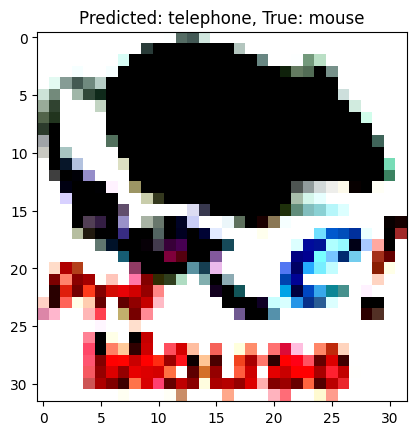

Image 1500:
Predicted Class: 86 (telephone)
True Class: 50 (mouse)
Confidence: 0.2768
Prediction is 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


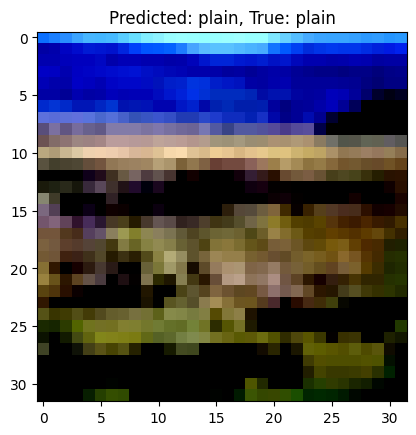

Image 1600:
Predicted Class: 60 (plain)
True Class: 60 (plain)
Confidence: 0.8568
Prediction is 1!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


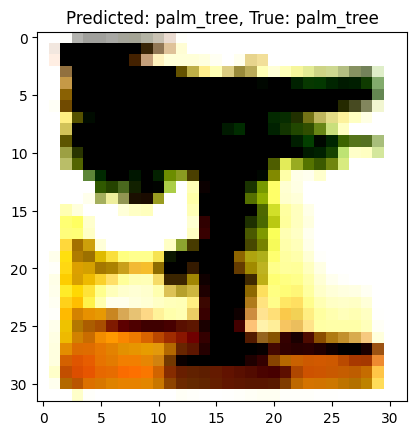

Image 1700:
Predicted Class: 56 (palm_tree)
True Class: 56 (palm_tree)
Confidence: 0.5185
Prediction is 1!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


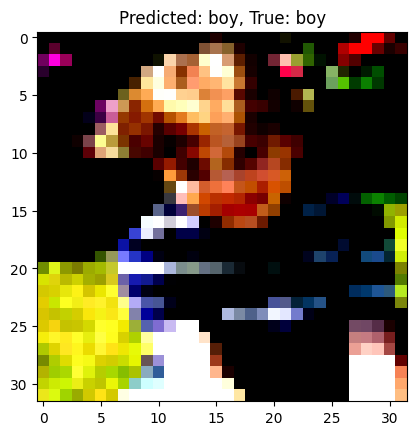

Image 1800:
Predicted Class: 11 (boy)
True Class: 11 (boy)
Confidence: 0.5871
Prediction is 1!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


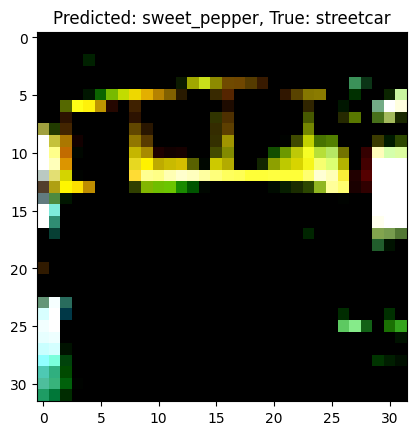

Image 1900:
Predicted Class: 83 (sweet_pepper)
True Class: 81 (streetcar)
Confidence: 0.2121
Prediction is 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


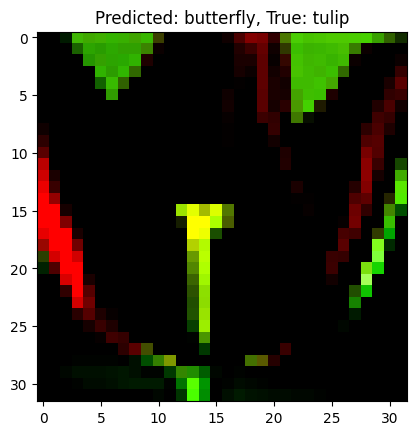

Image 2000:
Predicted Class: 14 (butterfly)
True Class: 92 (tulip)
Confidence: 0.3619
Prediction is 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


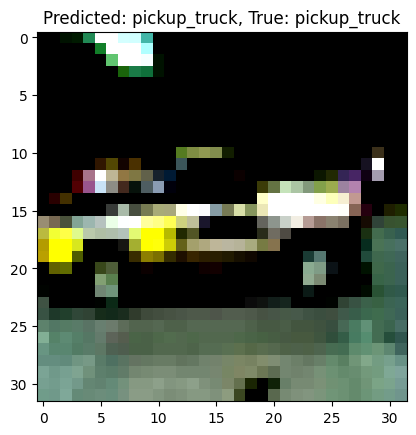

Image 2100:
Predicted Class: 58 (pickup_truck)
True Class: 58 (pickup_truck)
Confidence: 0.2964
Prediction is 1!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


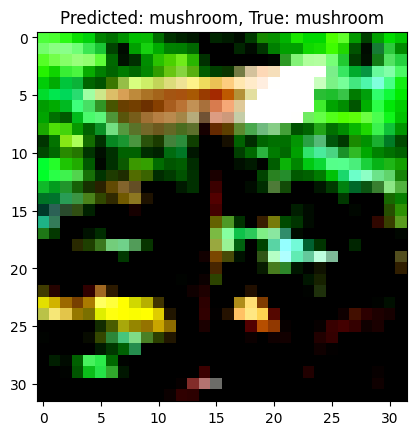

Image 2200:
Predicted Class: 51 (mushroom)
True Class: 51 (mushroom)
Confidence: 0.2024
Prediction is 1!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


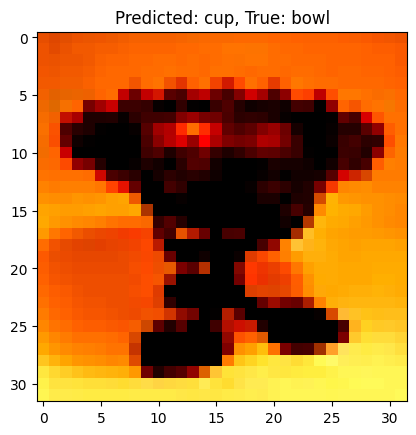

Image 2300:
Predicted Class: 28 (cup)
True Class: 10 (bowl)
Confidence: 0.7504
Prediction is 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


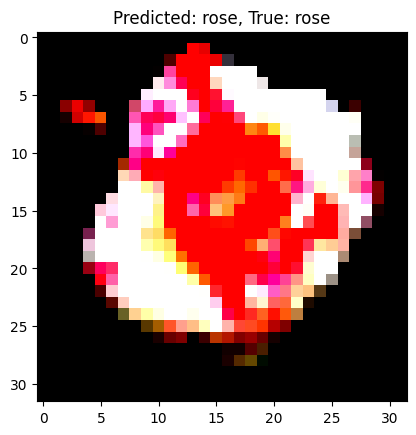

Image 2400:
Predicted Class: 70 (rose)
True Class: 70 (rose)
Confidence: 0.8421
Prediction is 1!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


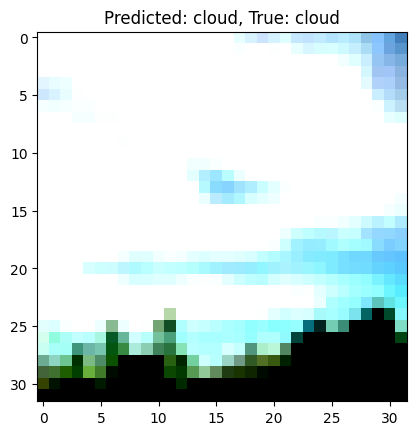

Image 2500:
Predicted Class: 23 (cloud)
True Class: 23 (cloud)
Confidence: 0.5244
Prediction is 1!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


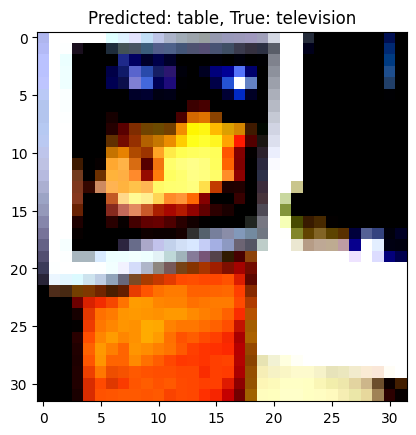

Image 2600:
Predicted Class: 84 (table)
True Class: 87 (television)
Confidence: 0.1233
Prediction is 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


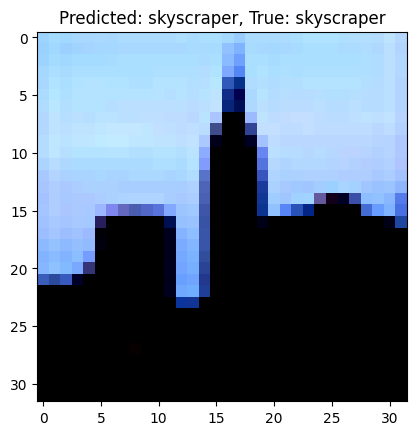

Image 2700:
Predicted Class: 76 (skyscraper)
True Class: 76 (skyscraper)
Confidence: 0.7135
Prediction is 1!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


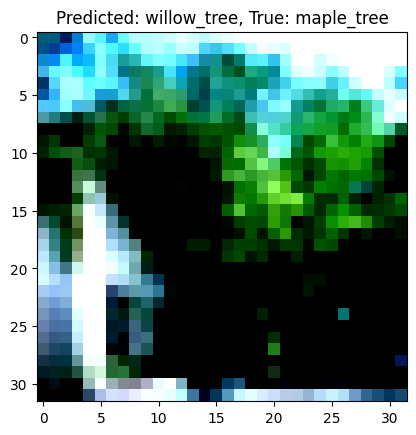

Image 2800:
Predicted Class: 96 (willow_tree)
True Class: 47 (maple_tree)
Confidence: 0.5030
Prediction is 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


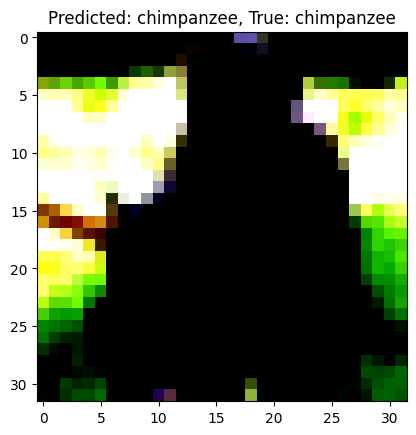

Image 2900:
Predicted Class: 21 (chimpanzee)
True Class: 21 (chimpanzee)
Confidence: 0.7197
Prediction is 1!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


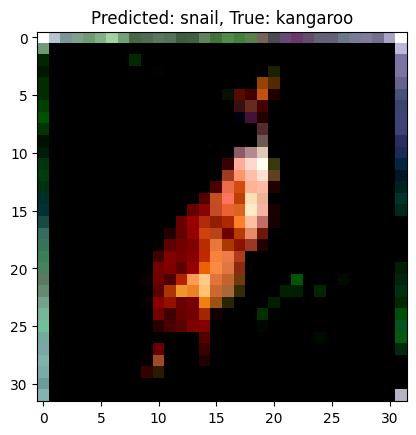

Image 3000:
Predicted Class: 77 (snail)
True Class: 38 (kangaroo)
Confidence: 0.1962
Prediction is 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


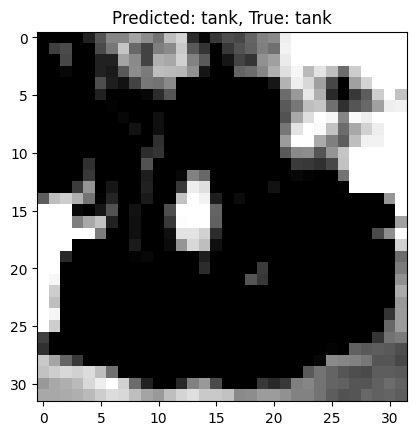

Image 3100:
Predicted Class: 85 (tank)
True Class: 85 (tank)
Confidence: 0.3938
Prediction is 1!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


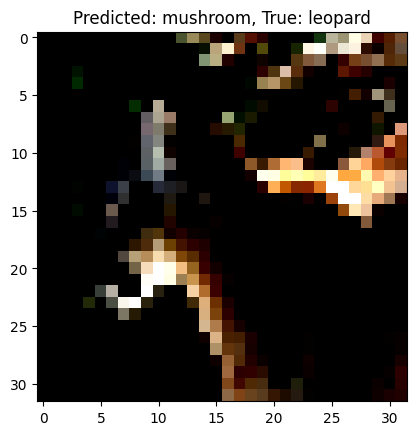

Image 3200:
Predicted Class: 51 (mushroom)
True Class: 42 (leopard)
Confidence: 0.1283
Prediction is 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


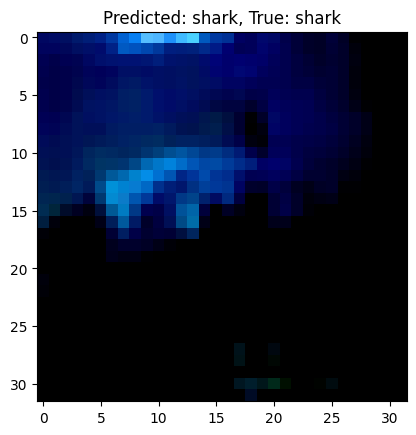

Image 3300:
Predicted Class: 73 (shark)
True Class: 73 (shark)
Confidence: 0.6964
Prediction is 1!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


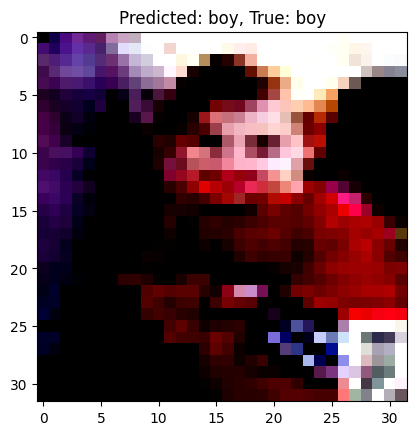

Image 3400:
Predicted Class: 11 (boy)
True Class: 11 (boy)
Confidence: 0.5756
Prediction is 1!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


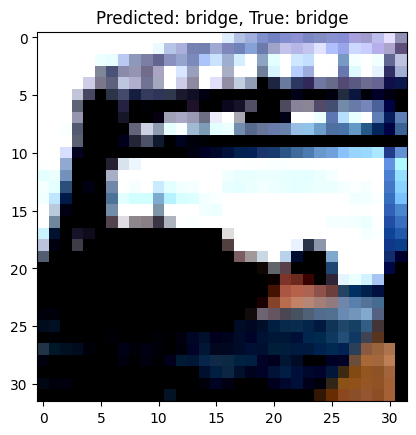

Image 3500:
Predicted Class: 12 (bridge)
True Class: 12 (bridge)
Confidence: 0.4196
Prediction is 1!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


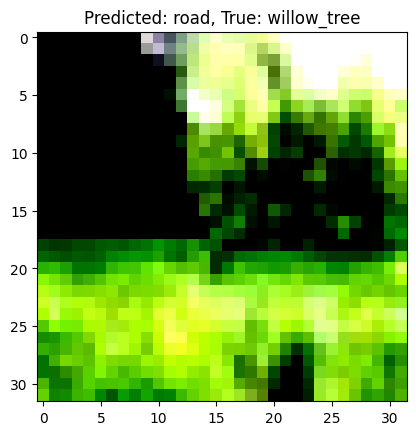

Image 3600:
Predicted Class: 68 (road)
True Class: 96 (willow_tree)
Confidence: 0.4268
Prediction is 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


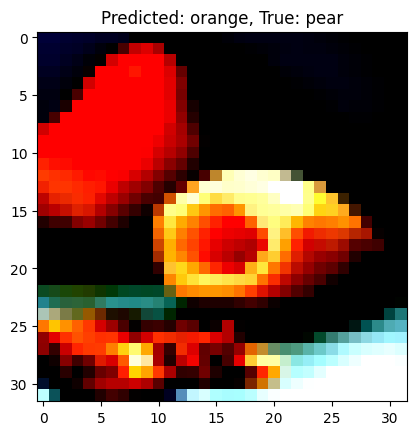

Image 3700:
Predicted Class: 53 (orange)
True Class: 57 (pear)
Confidence: 0.6919
Prediction is 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


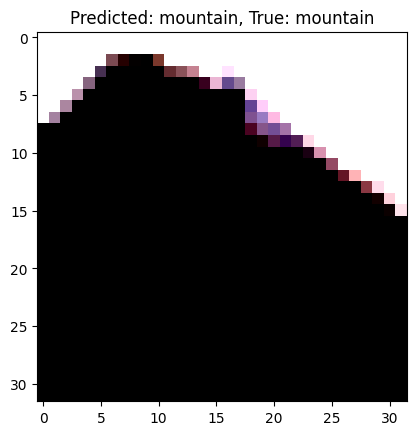

Image 3800:
Predicted Class: 49 (mountain)
True Class: 49 (mountain)
Confidence: 0.3530
Prediction is 1!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


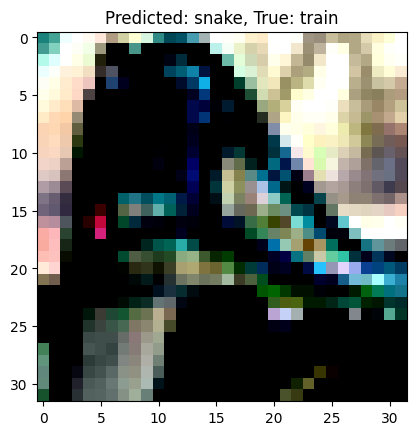

Image 3900:
Predicted Class: 78 (snake)
True Class: 90 (train)
Confidence: 0.1976
Prediction is 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


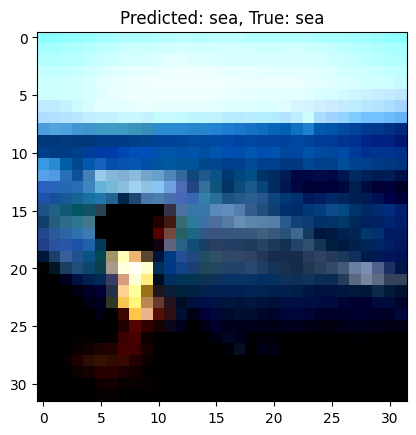

Image 4000:
Predicted Class: 71 (sea)
True Class: 71 (sea)
Confidence: 0.6361
Prediction is 1!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


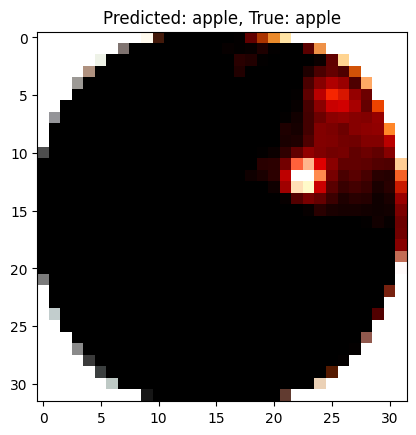

Image 4100:
Predicted Class: 0 (apple)
True Class: 0 (apple)
Confidence: 0.9112
Prediction is 1!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


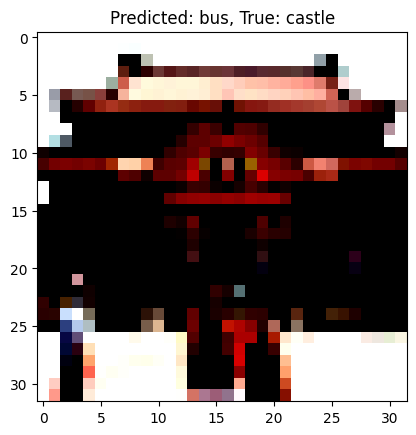

Image 4200:
Predicted Class: 13 (bus)
True Class: 17 (castle)
Confidence: 0.2355
Prediction is 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


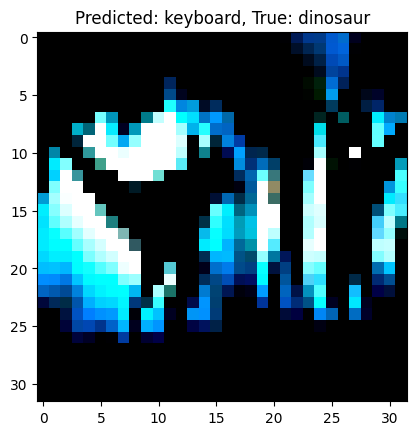

Image 4300:
Predicted Class: 39 (keyboard)
True Class: 29 (dinosaur)
Confidence: 0.1061
Prediction is 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


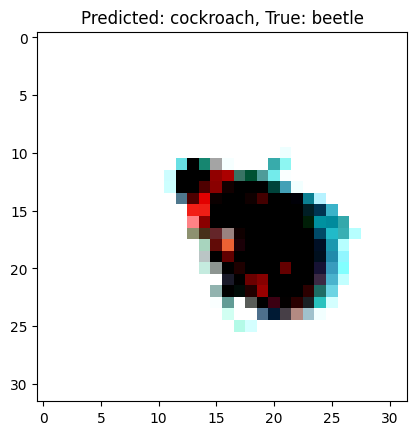

Image 4400:
Predicted Class: 24 (cockroach)
True Class: 7 (beetle)
Confidence: 0.6859
Prediction is 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


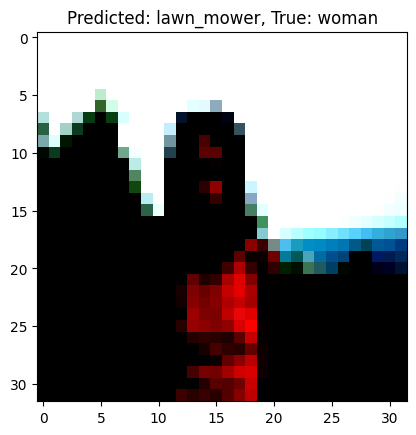

Image 4500:
Predicted Class: 41 (lawn_mower)
True Class: 98 (woman)
Confidence: 0.3638
Prediction is 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


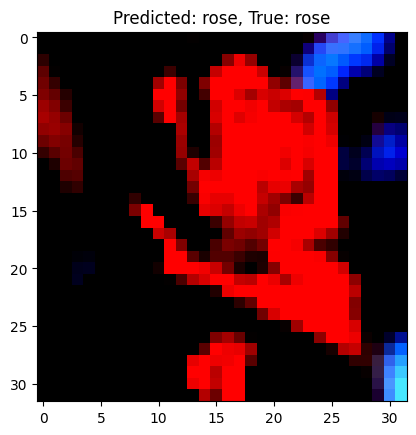

Image 4600:
Predicted Class: 70 (rose)
True Class: 70 (rose)
Confidence: 0.4537
Prediction is 1!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


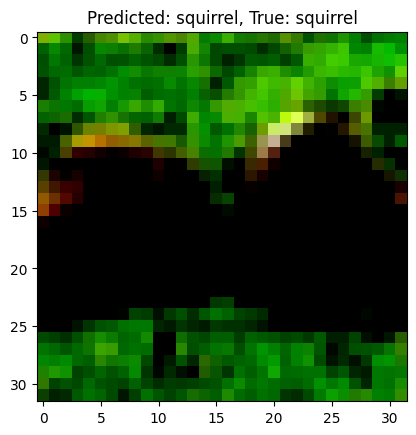

Image 4700:
Predicted Class: 80 (squirrel)
True Class: 80 (squirrel)
Confidence: 0.2911
Prediction is 1!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


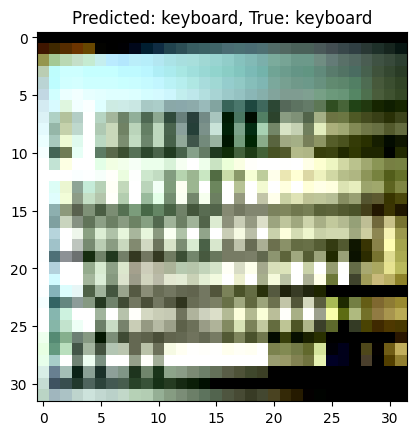

Image 4800:
Predicted Class: 39 (keyboard)
True Class: 39 (keyboard)
Confidence: 0.9893
Prediction is 1!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


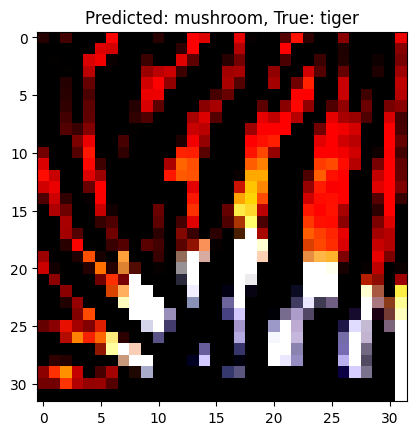

Image 4900:
Predicted Class: 51 (mushroom)
True Class: 88 (tiger)
Confidence: 0.1456
Prediction is 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


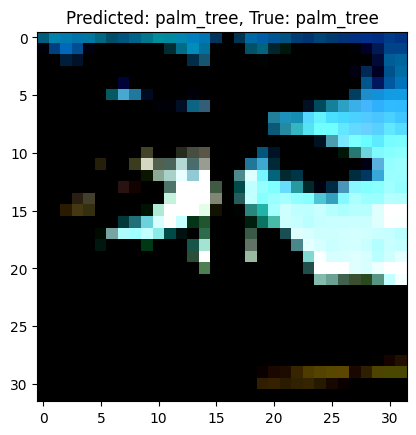

Image 5000:
Predicted Class: 56 (palm_tree)
True Class: 56 (palm_tree)
Confidence: 0.4662
Prediction is 1!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


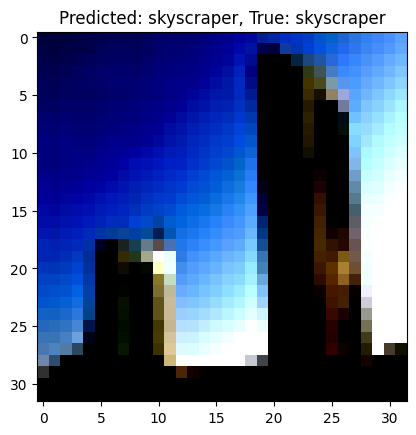

Image 5100:
Predicted Class: 76 (skyscraper)
True Class: 76 (skyscraper)
Confidence: 0.5626
Prediction is 1!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


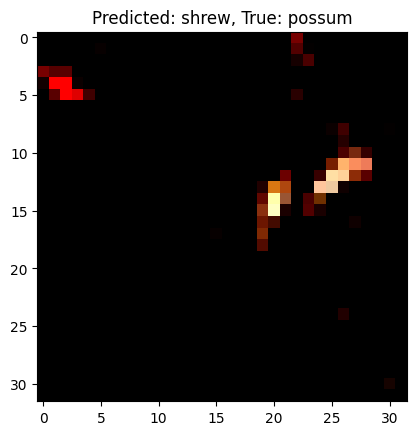

Image 5200:
Predicted Class: 74 (shrew)
True Class: 64 (possum)
Confidence: 0.6796
Prediction is 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


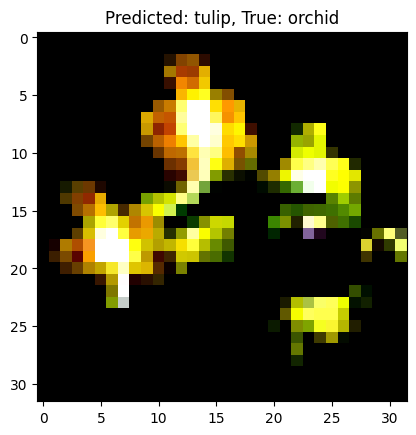

Image 5300:
Predicted Class: 92 (tulip)
True Class: 54 (orchid)
Confidence: 0.2058
Prediction is 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


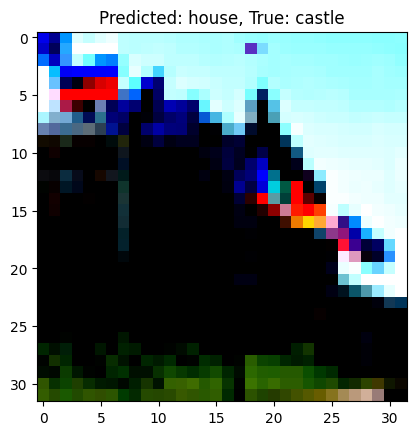

Image 5400:
Predicted Class: 37 (house)
True Class: 17 (castle)
Confidence: 0.4301
Prediction is 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


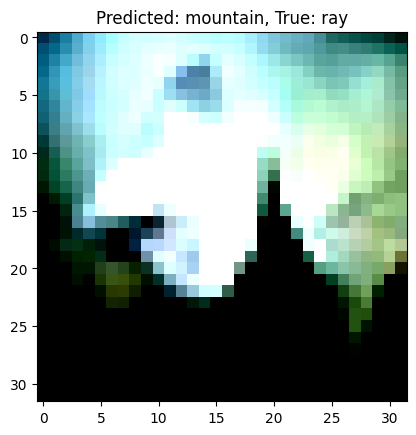

Image 5500:
Predicted Class: 49 (mountain)
True Class: 67 (ray)
Confidence: 0.1227
Prediction is 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


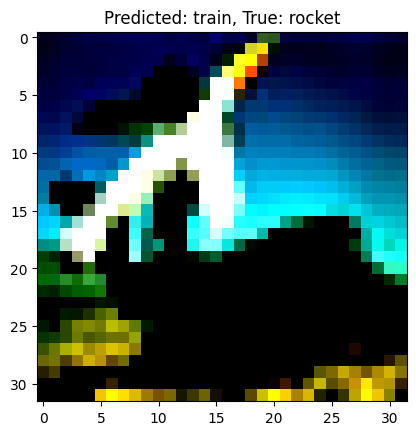

Image 5600:
Predicted Class: 90 (train)
True Class: 69 (rocket)
Confidence: 0.4051
Prediction is 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


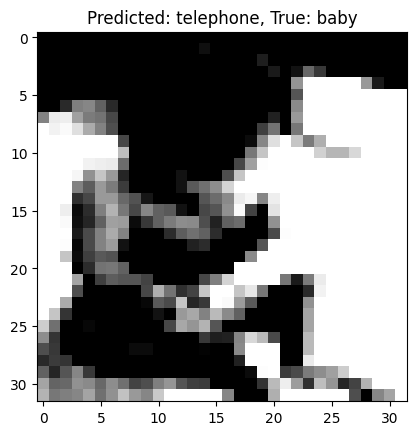

Image 5700:
Predicted Class: 86 (telephone)
True Class: 2 (baby)
Confidence: 0.1685
Prediction is 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


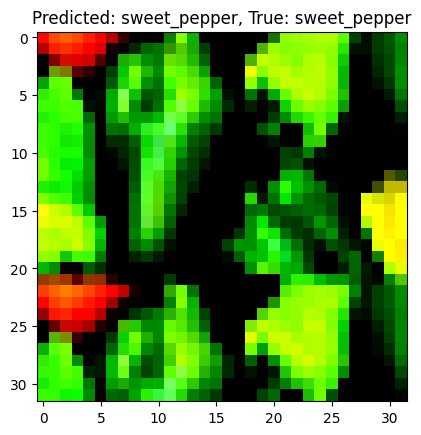

Image 5800:
Predicted Class: 83 (sweet_pepper)
True Class: 83 (sweet_pepper)
Confidence: 0.6178
Prediction is 1!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


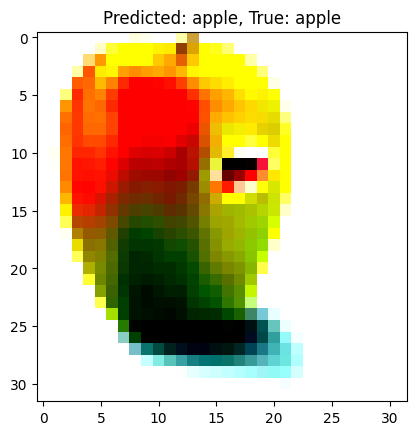

Image 5900:
Predicted Class: 0 (apple)
True Class: 0 (apple)
Confidence: 0.7437
Prediction is 1!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


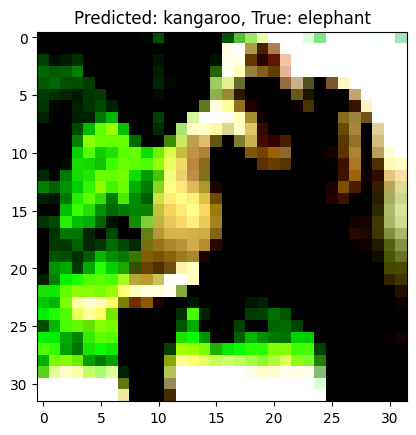

Image 6000:
Predicted Class: 38 (kangaroo)
True Class: 31 (elephant)
Confidence: 0.1069
Prediction is 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


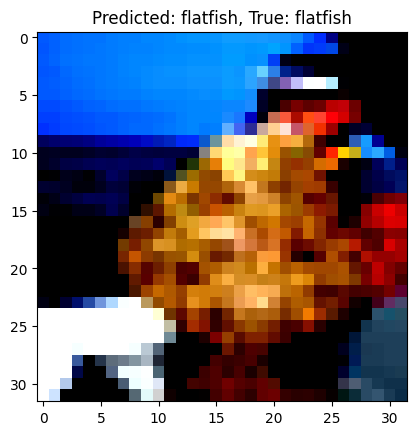

Image 6100:
Predicted Class: 32 (flatfish)
True Class: 32 (flatfish)
Confidence: 0.8827
Prediction is 1!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


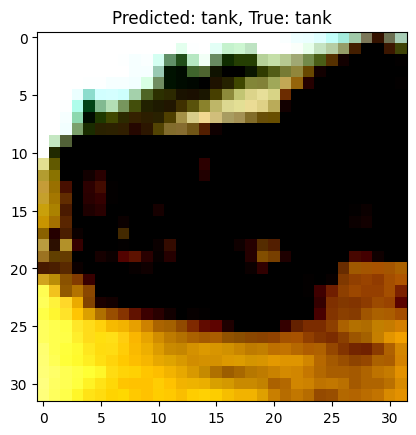

Image 6200:
Predicted Class: 85 (tank)
True Class: 85 (tank)
Confidence: 0.8141
Prediction is 1!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


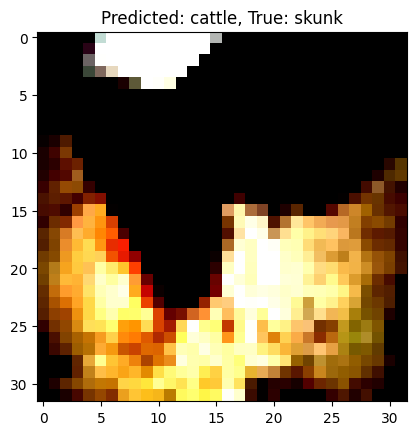

Image 6300:
Predicted Class: 19 (cattle)
True Class: 75 (skunk)
Confidence: 0.1503
Prediction is 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


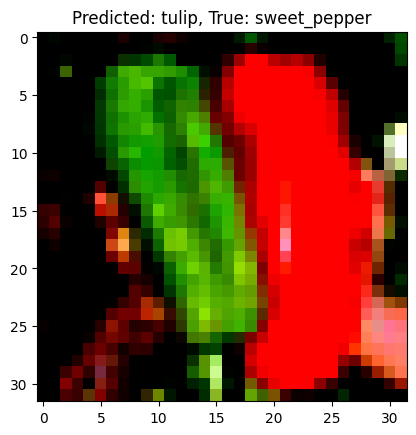

Image 6400:
Predicted Class: 92 (tulip)
True Class: 83 (sweet_pepper)
Confidence: 0.2867
Prediction is 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


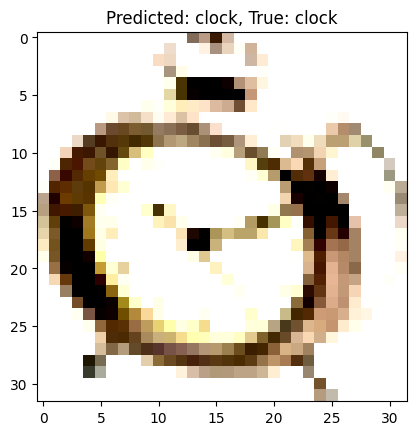

Image 6500:
Predicted Class: 22 (clock)
True Class: 22 (clock)
Confidence: 0.8325
Prediction is 1!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


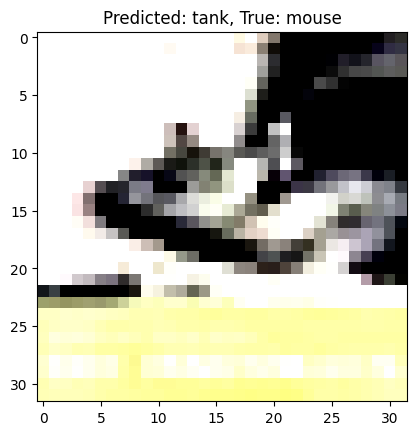

Image 6600:
Predicted Class: 85 (tank)
True Class: 50 (mouse)
Confidence: 0.1803
Prediction is 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


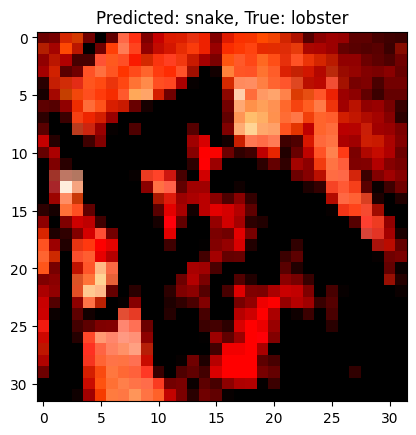

Image 6700:
Predicted Class: 78 (snake)
True Class: 45 (lobster)
Confidence: 0.4885
Prediction is 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


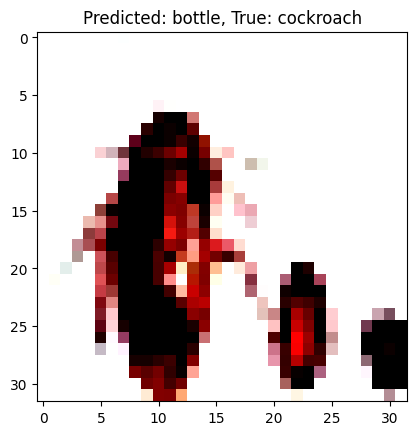

Image 6800:
Predicted Class: 9 (bottle)
True Class: 24 (cockroach)
Confidence: 0.1852
Prediction is 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


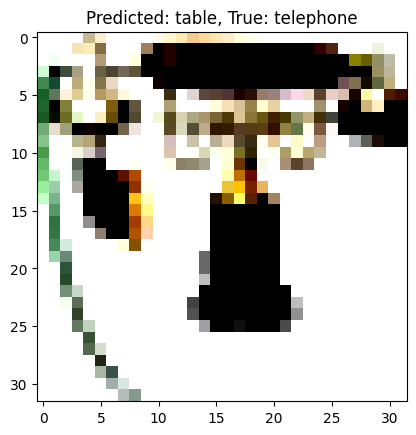

Image 6900:
Predicted Class: 84 (table)
True Class: 86 (telephone)
Confidence: 0.2311
Prediction is 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


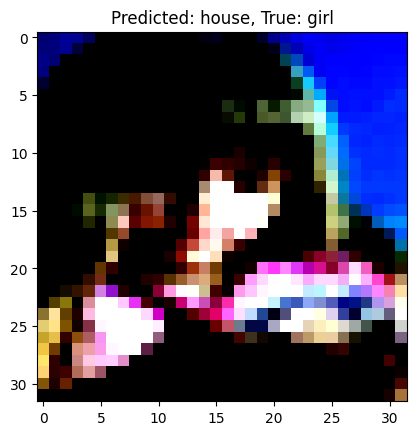

Image 7000:
Predicted Class: 37 (house)
True Class: 35 (girl)
Confidence: 0.1549
Prediction is 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


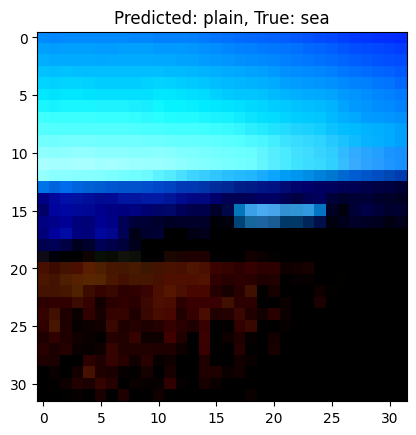

Image 7100:
Predicted Class: 60 (plain)
True Class: 71 (sea)
Confidence: 0.5618
Prediction is 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


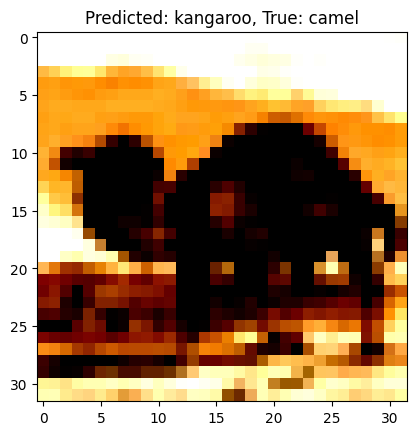

Image 7200:
Predicted Class: 38 (kangaroo)
True Class: 15 (camel)
Confidence: 0.2353
Prediction is 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


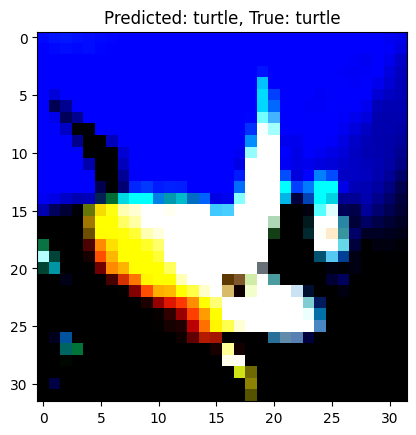

Image 7300:
Predicted Class: 93 (turtle)
True Class: 93 (turtle)
Confidence: 0.3133
Prediction is 1!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


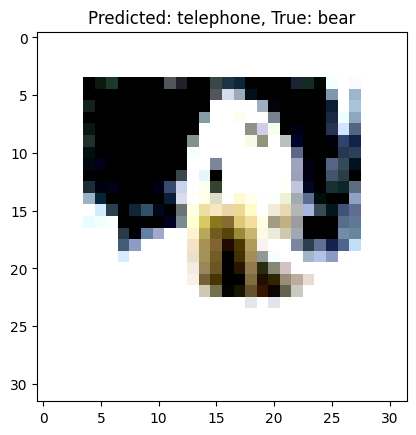

Image 7400:
Predicted Class: 86 (telephone)
True Class: 3 (bear)
Confidence: 0.1785
Prediction is 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


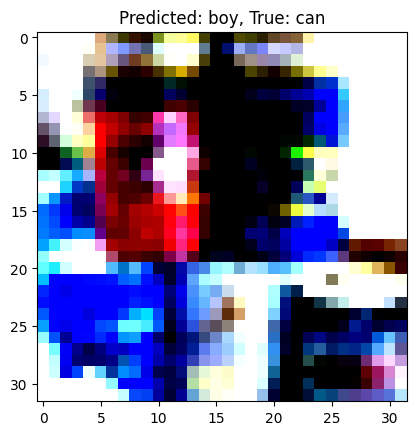

Image 7500:
Predicted Class: 11 (boy)
True Class: 16 (can)
Confidence: 0.3927
Prediction is 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


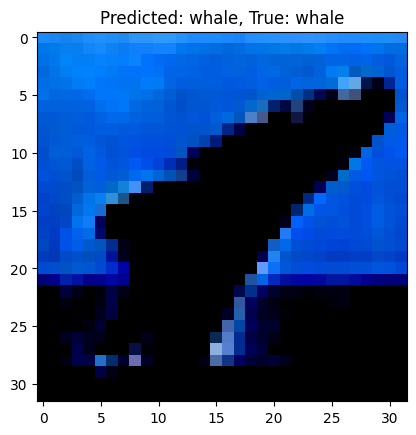

Image 7600:
Predicted Class: 95 (whale)
True Class: 95 (whale)
Confidence: 0.9823
Prediction is 1!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


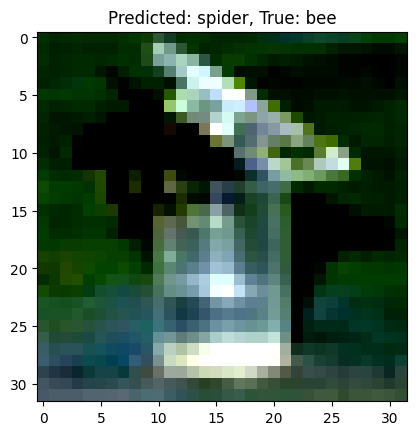

Image 7700:
Predicted Class: 79 (spider)
True Class: 6 (bee)
Confidence: 0.1738
Prediction is 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


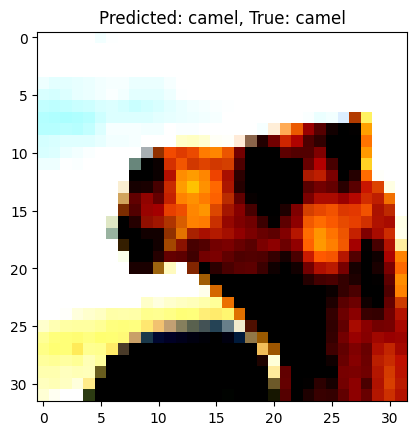

Image 7800:
Predicted Class: 15 (camel)
True Class: 15 (camel)
Confidence: 0.6176
Prediction is 1!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


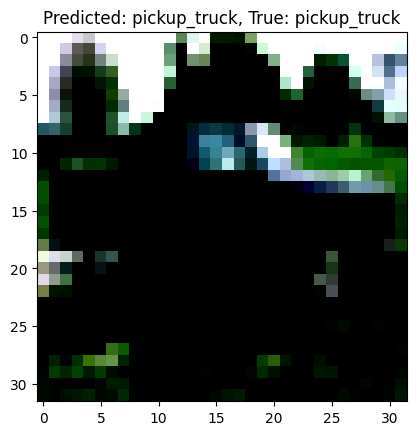

Image 7900:
Predicted Class: 58 (pickup_truck)
True Class: 58 (pickup_truck)
Confidence: 0.5864
Prediction is 1!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


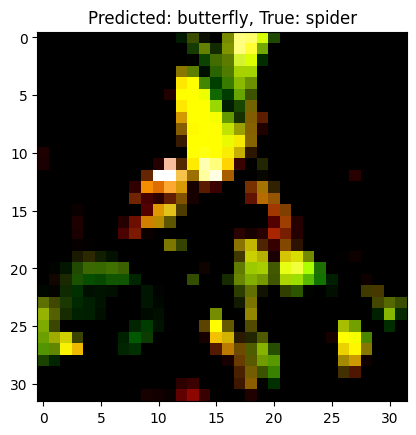

Image 8000:
Predicted Class: 14 (butterfly)
True Class: 79 (spider)
Confidence: 0.2449
Prediction is 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


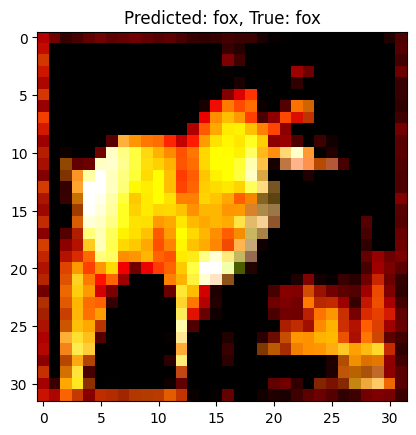

Image 8100:
Predicted Class: 34 (fox)
True Class: 34 (fox)
Confidence: 0.5238
Prediction is 1!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


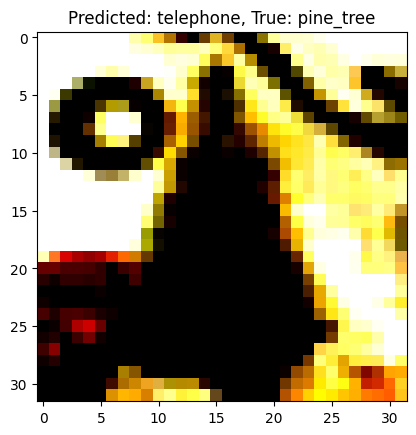

Image 8200:
Predicted Class: 86 (telephone)
True Class: 59 (pine_tree)
Confidence: 0.4324
Prediction is 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


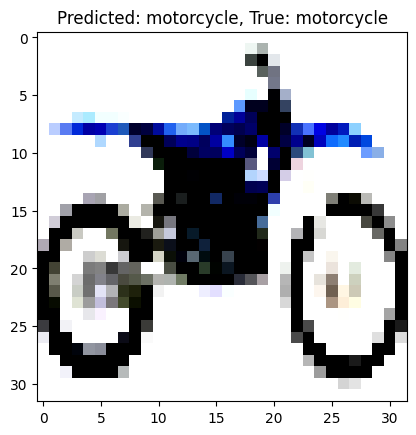

Image 8300:
Predicted Class: 48 (motorcycle)
True Class: 48 (motorcycle)
Confidence: 0.9849
Prediction is 1!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


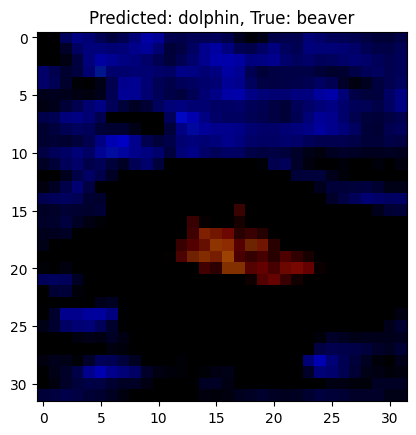

Image 8400:
Predicted Class: 30 (dolphin)
True Class: 4 (beaver)
Confidence: 0.2340
Prediction is 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


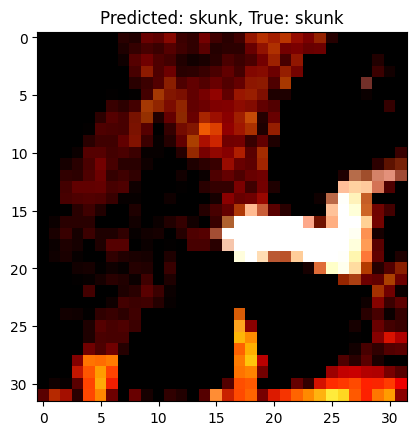

Image 8500:
Predicted Class: 75 (skunk)
True Class: 75 (skunk)
Confidence: 0.9238
Prediction is 1!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


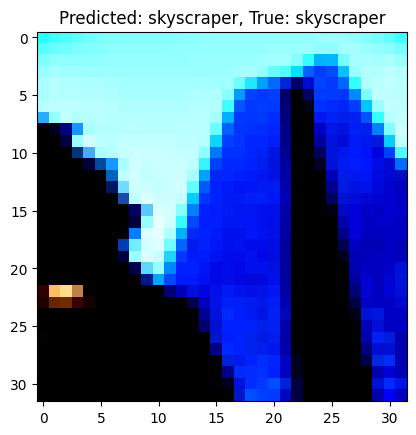

Image 8600:
Predicted Class: 76 (skyscraper)
True Class: 76 (skyscraper)
Confidence: 0.8121
Prediction is 1!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


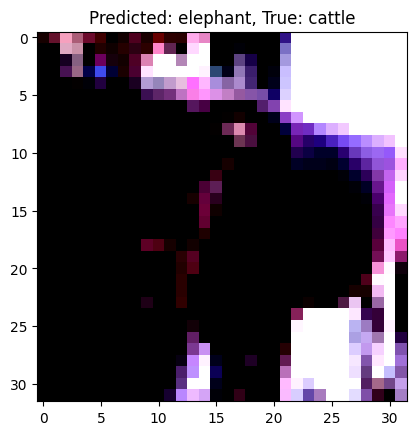

Image 8700:
Predicted Class: 31 (elephant)
True Class: 19 (cattle)
Confidence: 0.5918
Prediction is 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


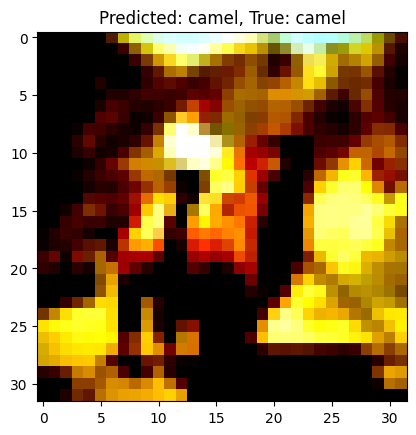

Image 8800:
Predicted Class: 15 (camel)
True Class: 15 (camel)
Confidence: 0.1710
Prediction is 1!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


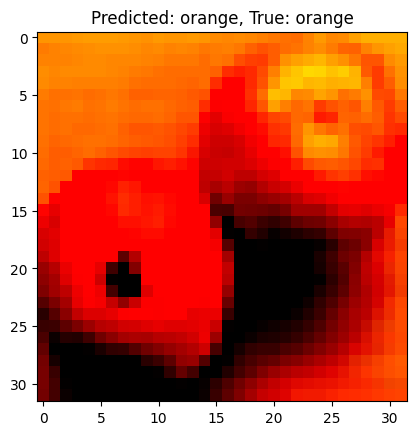

Image 8900:
Predicted Class: 53 (orange)
True Class: 53 (orange)
Confidence: 0.4735
Prediction is 1!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


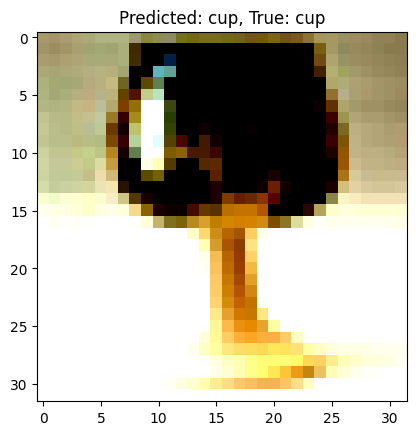

Image 9000:
Predicted Class: 28 (cup)
True Class: 28 (cup)
Confidence: 0.9936
Prediction is 1!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


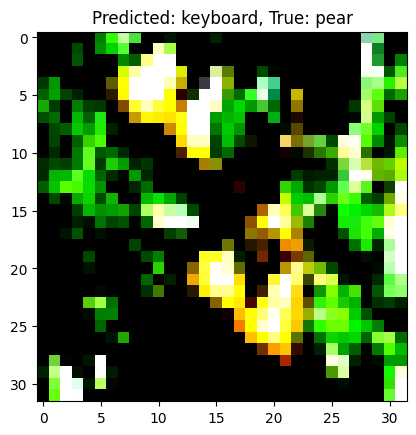

Image 9100:
Predicted Class: 39 (keyboard)
True Class: 57 (pear)
Confidence: 0.2086
Prediction is 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


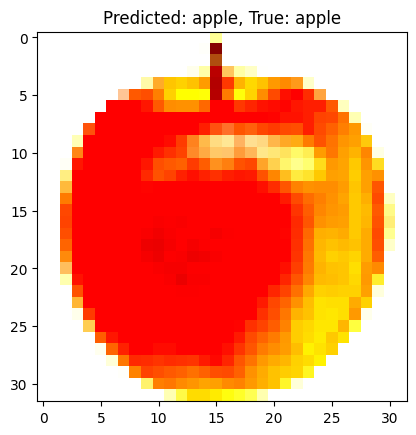

Image 9200:
Predicted Class: 0 (apple)
True Class: 0 (apple)
Confidence: 0.9009
Prediction is 1!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


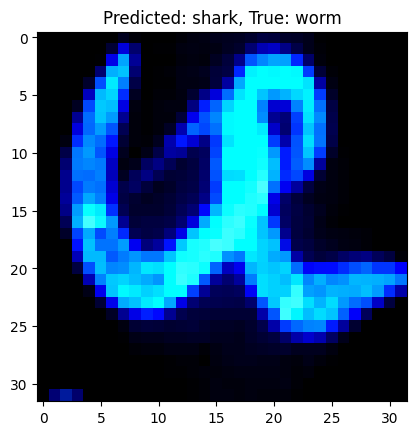

Image 9300:
Predicted Class: 73 (shark)
True Class: 99 (worm)
Confidence: 0.2881
Prediction is 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


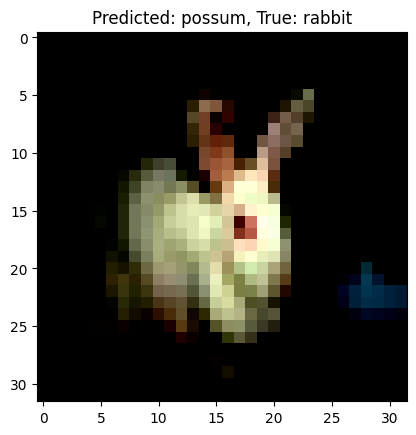

Image 9400:
Predicted Class: 64 (possum)
True Class: 65 (rabbit)
Confidence: 0.4842
Prediction is 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


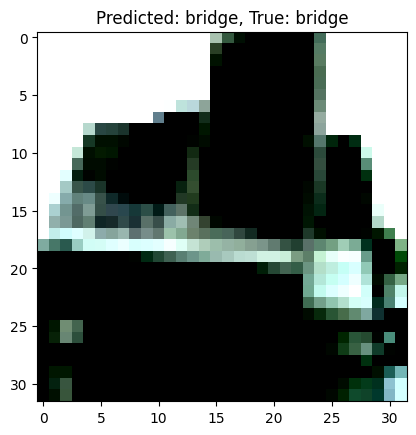

Image 9500:
Predicted Class: 12 (bridge)
True Class: 12 (bridge)
Confidence: 0.7371
Prediction is 1!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


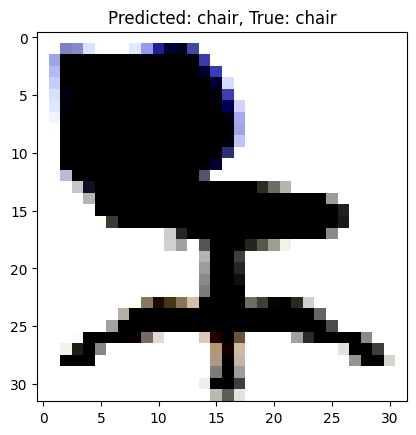

Image 9600:
Predicted Class: 20 (chair)
True Class: 20 (chair)
Confidence: 0.9716
Prediction is 1!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


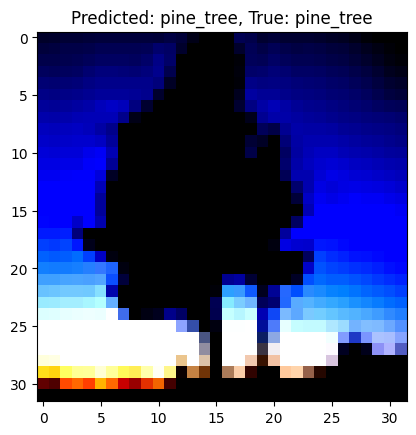

Image 9700:
Predicted Class: 59 (pine_tree)
True Class: 59 (pine_tree)
Confidence: 0.4661
Prediction is 1!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


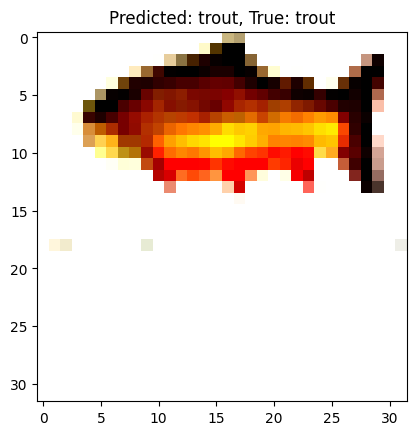

Image 9800:
Predicted Class: 91 (trout)
True Class: 91 (trout)
Confidence: 0.6501
Prediction is 1!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


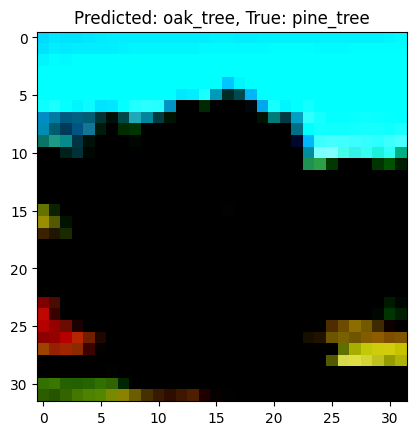

Image 9900:
Predicted Class: 52 (oak_tree)
True Class: 59 (pine_tree)
Confidence: 0.7071
Prediction is 0.


Prediction Results Table:
    Image_Index Predicted_Class   True_Class Confidence  Correct
0             0          bridge     mountain     0.4573    False
1           100        dinosaur         crab     0.1000    False
2           200             bee          bee     0.3562     True
3           300        elephant  willow_tree     0.1661    False
4           400            lamp         lamp     0.8123     True
..          ...             ...          ...        ...      ...
95         9500          bridge       bridge     0.7371     True
96         9600           chair        chair     0.9716     True
97         9700       pine_tree    pine_tree     0.4661     True
98         9800           trout        trout     0.6501     True
99         9900        oak_tree    pine_tree     0.7071    False

[100 rows x 5 columns]


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Initialize lists to store results
results = []

# Load the best model (assuming it's saved with all layers, including custom objects if any)
#model = tf.keras.models.load_model('/content/googlenet.h5')


for i in range(100):
    # Get the test image and its true label
    image = x_test[i * 100]  # Shape: (224, 224, 3) after resizing
    true_class_one_hot = y_test[i * 100]  # Shape: (100,) - one-hot encoded vector
    true_class = np.argmax(true_class_one_hot)  # Get the index of the true class

    # Add batch dimension to the image
    image = np.expand_dims(image, axis=0)  # Shape: (1, 224, 224, 3)

    # Make prediction (model returns three outputs)
    predictions = model_with_custom_pool.predict(image)  # Returns a list: [main_output, aux_output_1, aux_output_2]
    predicted_class = np.argmax(predictions, axis=1)[0]  # Use main_output for final prediction
    confidence = np.max(predictions)  # Confidence from main_output

    # Store results in dictionary
    results.append({
        'Image_Index': i * 100,
        'Predicted_Class': cifar100_labels[predicted_class],
        'True_Class': cifar100_labels[true_class],
        'Confidence': f"{confidence:.4f}",
        'Correct': predicted_class == true_class
    })

    # Visualize the image
    plt.imshow(x_test[i * 100])  # Show original 32x32 image for visualization
    plt.title(f"Predicted: {cifar100_labels[predicted_class]}, True: {cifar100_labels[true_class]}")
    plt.show()

    # Print results
    print(f"Image {i * 100}:")
    print(f"Predicted Class: {predicted_class} ({cifar100_labels[predicted_class]})")
    print(f"True Class: {true_class} ({cifar100_labels[true_class]})")
    print(f"Confidence: {confidence:.4f}")
    print("Prediction is 1!" if predicted_class == true_class else "Prediction is 0.")
    print()

# Create and display DataFrame
results_df = pd.DataFrame(results)
print("\nPrediction Results Table:")
print(results_df)

# Optionally save to CSV
results_df.to_csv('/content/prediction_results.csv', index=False)  # Save to Google Drive

In [ ]:
import pandas as pd

# Read the CSV file (replace 'data.csv' with your file name)
df = pd.read_csv('prediction_results.csv')

# Assume the boolean column is named 'value' (replace with your column name)
column_name = 'Correct'

# Calculate the percentage of True values
true_count = df[column_name].sum()  # True is treated as 1, False as 0
total_count = len(df)
true_percentage = (true_count / total_count) * 100

# Print the result
print(f"Percentage of True values: {true_percentage:.2f}%")

Percentage of True values: 45.00%
